# Probability maps animation

This notebook creates an animation showing the evolution of the predicted time-dependent deposit probability from 170Ma-present. The notebook `02-create_probability_maps.ipynb` must have been run previously.

If training data has been extracted from the source datasets by running the `00c-extract_training_data_global.ipynb` and `00b-extract_grid_data.ipynb` notebooks, set the `use_extracted_data` variable below to `True` to use this dataset instead of the pre-prepared training data from the [Zenodo repository](https://zenodo.org/record/8157691).

## Notebook options

These cells set some of the important variables and definitions used throughout the notebook.

In [1]:
config_file = "notebook_parameters_deformation.yml"

In [2]:
from lib.load_params import get_params

params = get_params(config_file, notebook="03")

# If True, use training data extracted in notebook 00c
# Else, use pre-prepared training data downloaded from Zenodo
use_extracted_data = params["use_extracted_data"]

# Number of processes to use
n_jobs = params["n_jobs"]

# Overwrite any existing output files
overwrite = params["overwrite_output"]

# Control verbosity level of logging output
verbose = params["verbose"]

# Timespan for analysis
min_time = params["timespan"]["min"]
max_time = params["timespan"]["max"]
times = range(min_time, max_time + 1)

# Output directory
output_dir = params["output_dir"]

### Select plate model

To use the plate model from the published paper (Alfonso et al., 2024), set `use_provided_plate_model` to `True`. Otherwise, leave `use_provided_plate_model` as `False` and set `plate_model_name` to a valid model name for the [`plate-model-manager`](https://github.com/michaelchin/plate-model-manager/blob/4f66423b53950bf42f5dac1228e61fd1e19fdf6e/models.json) package, or set `plate_model_name` to `None` and place GPlates files in a directory named `plate_model`.

| `use_provided_plate_model` | `plate_model_name` | result |
| - | - | - |
| `True` | Any | Use Alfonso et al., 2024 model |
| `False` | Model name string (e.g. `"muller2022"`) | Use specified plate model |
| `False` | `None` | Use files in `plate_model` directory |

In [3]:
plate_model_name = params["plate_model"]["plate_model_name"]
use_provided_plate_model = params["plate_model"]["use_provided_plate_model"]

## Notebook setup

Imports, definitions, etc.

### Imports

In [4]:
import glob
import os
import tempfile
import warnings
from itertools import product

import cartopy.crs as ccrs
import pandas as pd
import pygplates
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    from gplately import (
        PlateReconstruction,
        PlotTopologies,
    )
from joblib import Parallel, delayed

from lib.animation import create_animation
from lib.check_files import (
    check_plate_model,
    check_prepared_data,
)
from lib.misc import (
    filter_topological_features,
    reconstruct_by_topologies,
)
from lib.plate_models import (
    get_plate_reconstruction,
    get_plot_topologies,
)
from lib.visualisation import plot

# Suppress occasional joblib warnings
%env PYTHONWARNINGS=ignore::UserWarning

NOTEBOOK = "get_ipython" in dir()

env: PYTHONWARNINGS=ignore::UserWarning


### Input and output files

If necessary, the plate model will be downloaded:

In [5]:
if use_extracted_data:
    data_dir = params["extracted_data_dir"]
else:
    data_dir = check_prepared_data("prepared_data", verbose=True)

plate_model_dir = "plate_model"
if use_provided_plate_model:
    check_plate_model(plate_model_dir, verbose=True)
    plate_model_name = None
plate_model, _tf = get_plate_reconstruction(
    model_name=plate_model_name,
    model_dir=plate_model_dir,
    filter_topologies=True,
)

if use_provided_plate_model:
    coastlines_filenames = [os.path.join(
        plate_model_dir,
        "StaticGeometries",
        "AgeGridInput",
        "CombinedTerranes.gpml",
    )]
    gplot = PlotTopologies(
        plate_model,
        coastlines=coastlines_filenames,
    )
else:
    gplot = get_plot_topologies(
        model_name=plate_model_name,
        model_dir=plate_model_dir,
        plate_reconstruction=plate_model,
        filter_topologies=True,
    )

output_dir = os.path.join(output_dir, "global")

### Plot options

These should generally be left unchanged.

In [6]:
lon_0 = 0.0
projection = ccrs.Mollweide(lon_0)

imshow_kwargs = dict(
    vmin=0,
    vmax=60,
    cmap="viridis"
)

### Load training data

The training dataset is used to plot deposit locations on the maps.

In [7]:
training_filename = os.path.join(data_dir, "training_data_global_deformation.csv")
training_data = pd.read_csv(training_filename)
positives = training_data[training_data["label"] == "positive"]

### Reconstruct deposit data for plots

In [8]:
positives = reconstruct_by_topologies(
    data=(positives[["lon", "lat", "age (Ma)", "label", "region"]]).copy(),
    plate_reconstruction=plate_model,
    times=times,
)

## Example plot

Create an example plot at a single time step (by default, 110 Ma).

PU example plot:


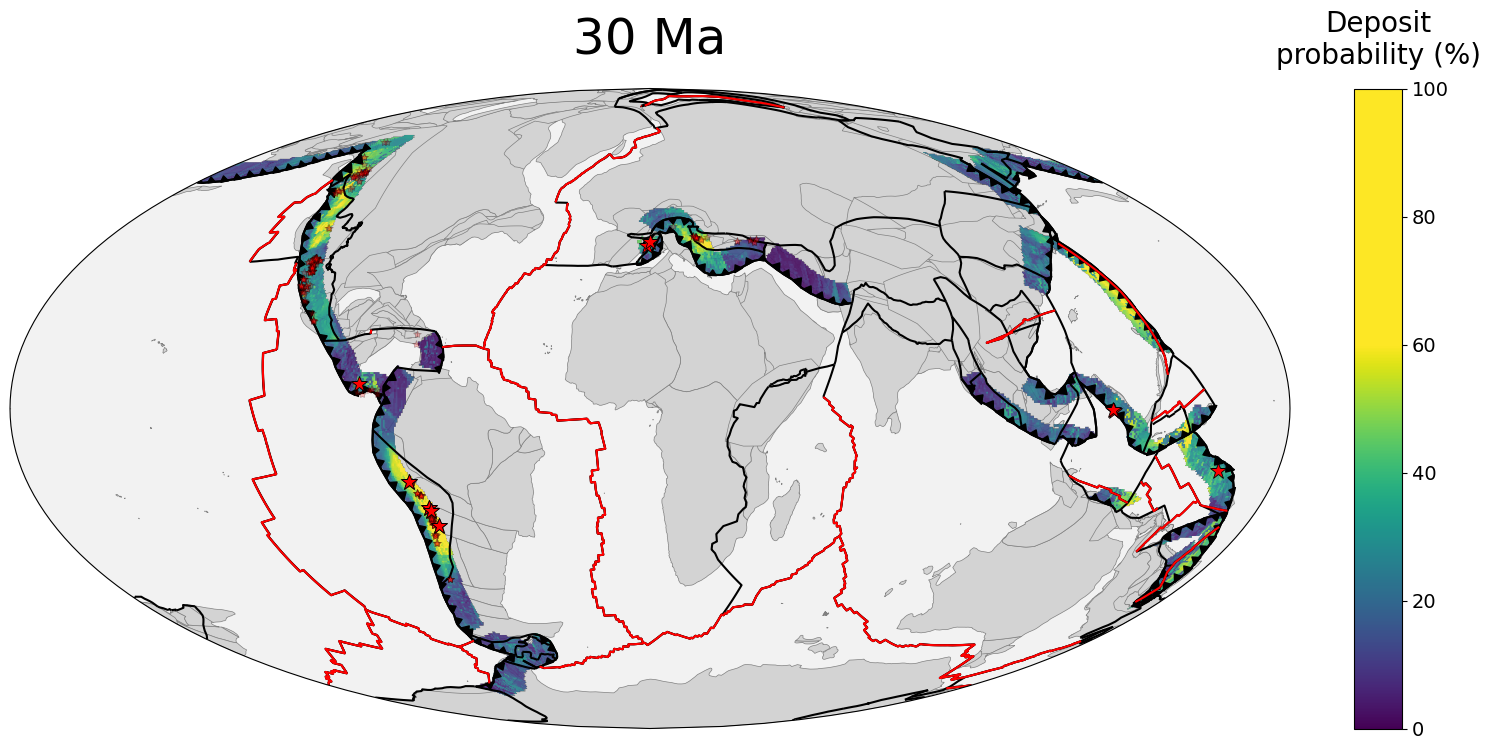

In [9]:
# Example plot (only in notebook)
if NOTEBOOK:
    t_example = 30  # Ma
    gplot.time = t_example
    algorithm = "PU"
    probs_dir = os.path.join(output_dir, algorithm, "probability_grids")

    print(f"{algorithm} example plot:")
    fig = plot(
        gplot=gplot,
        probabilities=os.path.join(
            probs_dir,
            f"probability_grid_{t_example:0.0f}Ma.nc",
        ),
        positives=positives,
        projection=projection,
        time=t_example,
        central_meridian=lon_0,
        imshow_kwargs=imshow_kwargs,
    )

## Create all plots

This will create the plots for all models.

In [10]:
for algorithm in ("PU", "SVM"):
    with tempfile.TemporaryDirectory() as tmpdir, \
            Parallel(
                n_jobs=n_jobs,
                verbose=int(verbose),
                pre_dispatch="all",
                batch_size=int(len(times) // n_jobs) + 1,
            ) as parallel:

        # Create animation for global model
        output_filename = os.path.join(
            output_dir,
            algorithm,
            "probability_animation.mp4",
        )
        probs_dir = os.path.join(output_dir, algorithm, "probability_grids")

        # Create all plots
        output_filenames = [
            os.path.join(tmpdir, f"image_{t:0.0f}Ma.png")
            for t in times
        ]
        parallel(
            delayed(plot)(
                gplot=gplot,
                probabilities=os.path.join(
                    probs_dir,
                    f"probability_grid_{t:0.0f}Ma.nc",
                ),
                projection=projection,
                time=t,
                positives=positives,
                output_filename=o,
                central_meridian=lon_0,
                imshow_kwargs=imshow_kwargs,
            )
            for t, o in zip(times, output_filenames)
        )
        create_animation(
            image_filenames=output_filenames[::-1],  # reverse order of frames (forward in time)
            output_filename=output_filename,
            fps=10,  # framerate of output video
            bitrate="5000k",
        )

        # Create animations for regional models
        for region, positives_region in positives.groupby("region"):
            r = "_".join(region.lower().split())
            probs_dir_region = os.path.join(output_dir, algorithm, f"probability_grids_{r}")
            if not os.path.isdir(probs_dir_region):
                continue
            output_filename_region = os.path.join(
                output_dir,
                algorithm,
                f"probability_animation_{r}.mp4",
            )
            parallel(
                delayed(plot)(
                    gplot=gplot,
                    probabilities=os.path.join(
                        probs_dir_region,
                        f"probability_grid_{t:0.0f}Ma.nc",
                    ),
                    projection=projection,
                    time=t,
                    positives=positives_region,
                    output_filename=o,
                    central_meridian=lon_0,
                    imshow_kwargs=imshow_kwargs,
                )
                for t, o in zip(times, output_filenames)
            )
            create_animation(
                image_filenames=output_filenames[::-1],
                output_filename=output_filename_region,
                fps=10,
                bitrate="5000k",
            )